In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Failed to set memory growth: {e}")

# Now proceed with the rest of your imports and model definition


In [2]:
import os
import shutil
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import math
from math import floor
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from keras.applications import VGG16
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [3]:
def display_data(parent_dir):
    # Step 1: Directory to disease mapping
    condition_types = {
        'Acitinic Keratosis': 'Precancerous',
        'Basal Cell Carcinoma': 'Cancerous',
        'Dermatofibroma': 'Non-cancerous',
        'Melanoma': 'Cancerous',
        'Nevus': 'Non-cancerous',
        'Pigmented Benign Keratosis': 'Non-cancerous',
        'Seborrheic Keratosis': 'Non-cancerous',
        'Squamous Cell Carcinoma': 'Cancerous',
        'Vascular Lesion': 'Non-cancerous'
    }

    # Step 2: Create a DataFrame with directory names and image counts
    data = {'Directory': [], 'File Count': [], 'Condition Type': []}

    # Step 3: Loop through directories, count images, and add condition type
    for dirpath, dirnames, filenames in os.walk(parent_dir):
        if dirpath != parent_dir:
            dir_name = os.path.basename(dirpath)
            file_count = len(filenames)
            condition_type = condition_types.get(dir_name, 'Unknown')  # Get the condition type from the mapping
            data['Directory'].append(dir_name)
            data['File Count'].append(file_count)
            data['Condition Type'].append(condition_type)

    # Create DataFrame
    df = pd.DataFrame(data)
    # Step 4: Add the color mapping
    colors = {'Cancerous': 'red', 'Precancerous': 'yellow', 'Non-cancerous': 'green'}

    # Set up the bar plot
    plt.figure(figsize=(10,6))
    bars = plt.bar(df['Directory'], df['File Count'], color=[colors[ctype] for ctype in df['Condition Type']])

    # Add title and labels
    plt.title('Number of Image per Skin Condition', fontsize=14)
    plt.xlabel('Skin Disease', fontsize=12)
    plt.ylabel('Image Count', fontsize=12)

    # Add a legend
    handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors.values()]
    labels = colors.keys()
    plt.legend(handles, labels, title="Condition Type")

    # Show the plot
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
    plt.tight_layout()
    plt.show()

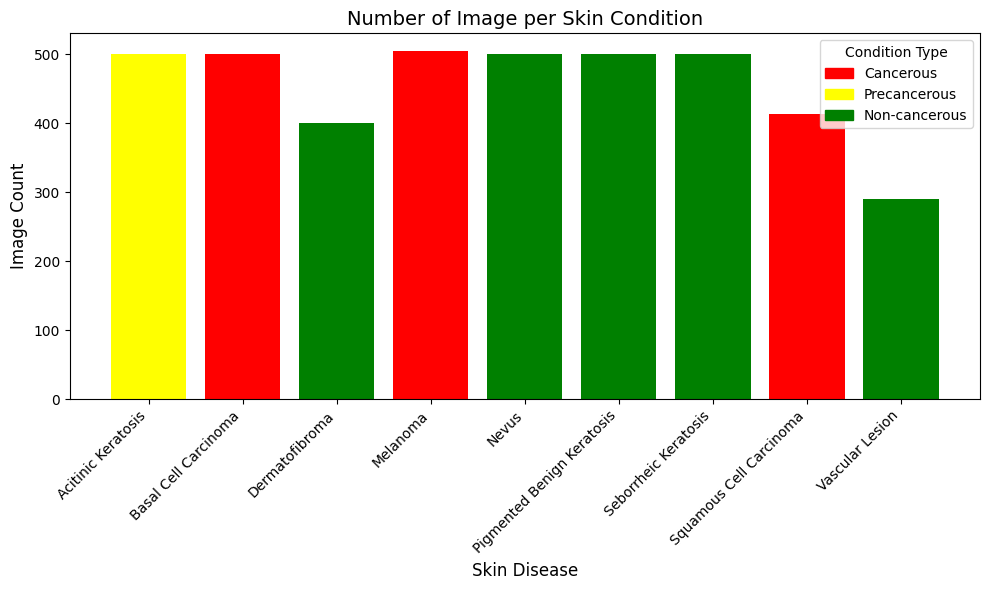

In [ ]:
display_data(parent_dir = 'Skin Cancer Dataset')

Displaying images for category: Acitinic Keratosis


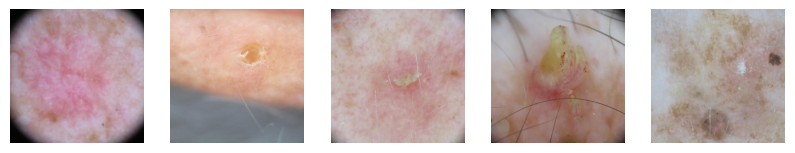

Displaying images for category: Basal Cell Carcinoma


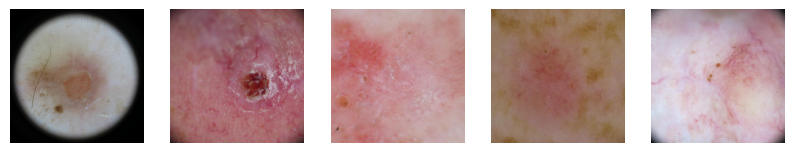

Displaying images for category: Dermatofibroma


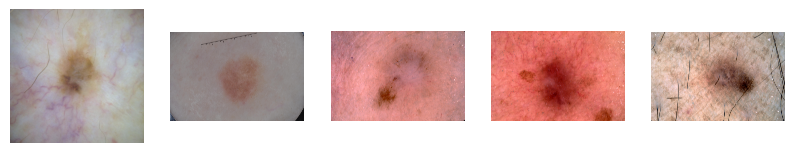

Displaying images for category: Melanoma


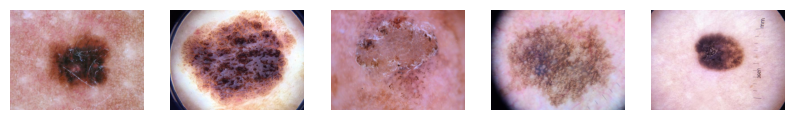

Displaying images for category: Nevus


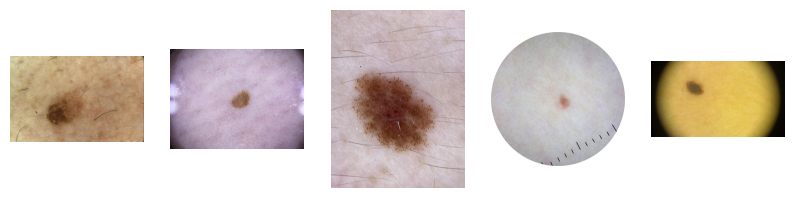

Displaying images for category: Pigmented Benign Keratosis


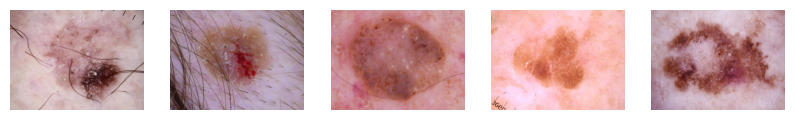

Displaying images for category: Seborrheic Keratosis


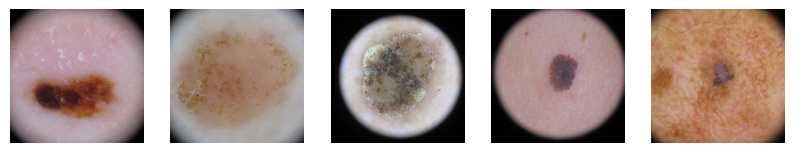

Displaying images for category: Squamous Cell Carcinoma


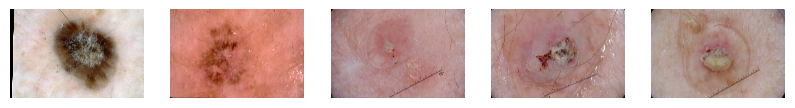

Displaying images for category: Vascular Lesion


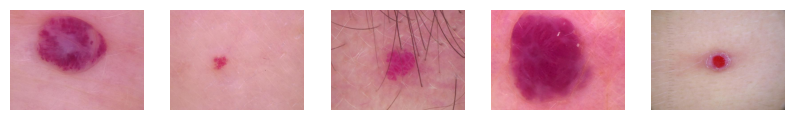

In [ ]:
parent_dir = 'Skin Cancer Dataset'

# Automatically retrieve the list of categories (subdirectories) from the parent directory
categories = [d for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d))]

# Function to display images from each category
def display_images_for_category(category_dir, num_images=5):
    image_files = [f for f in os.listdir(category_dir)]
    
    # Only proceed if there are images to display
    if len(image_files) == 0:
        print(f"No images found in {category_dir}. Skipping...")
        return
    
    # Display at least 5 images or all if fewer are available
    image_files = image_files[:num_images]
    
    # Set up the figure to display images
    fig, axes = plt.subplots(1, len(image_files), figsize=(10, 5))
    
    # If there's only one image, axes is not a list, handle that case
    if len(image_files) == 1:
        axes = [axes]
    
    # Display each image
    for i, image_file in enumerate(image_files):
        img_path = os.path.join(category_dir, image_file)
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')  # Hide axes
#         axes[i].set_title(f'{os.path.basename(category_dir)}')

    plt.show()

# Loop through each category and display at least 5 images
for category in categories:
    category_dir = os.path.join(parent_dir, category)
    if os.path.exists(category_dir):  # Check if the directory exists
        print(f"Displaying images for category: {category}")
        display_images_for_category(category_dir, num_images=5)
    else:
        print(f"Directory not found: {category_dir}")

Image Properties:
Filename: ISIC_0066408.JPG
Format: JPEG
Mode: RGB
Size: (1024, 1024)
Width: 1024
Height: 1024
Info: {'jfif': 257, 'jfif_version': (1, 1), 'jfif_unit': 0, 'jfif_density': (1, 1)}


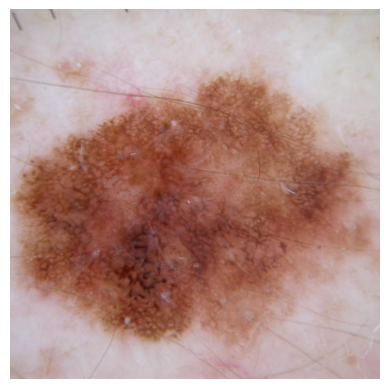

In [ ]:
def get_image_properties(image_path):
    try:
        # Open the image file
        with Image.open(image_path) as img:
            # Get image properties
            properties = {
                'Filename': os.path.basename(image_path),
                'Format': img.format,
                'Mode': img.mode,
                'Size': img.size,  # (width, height)
                'Width': img.width,
                'Height': img.height,
                'Info': img.info,  # Additional metadata
            }
            # Convert the image to a NumPy array for displaying
            img_array = np.array(img)
            return properties, img_array  # Return properties and image array
    except Exception as e:
        print(f"Error opening image: {e}")
        return None, None

def display_image(image):
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

# Example usage
image_path = "Skin Cancer Dataset\\Melanoma\\ISIC_0066408.JPG"  # Specify image path
properties, image = get_image_properties(image_path)

if properties:
    print("Image Properties:")
    for key, value in properties.items():
        print(f"{key}: {value}")
    
    # Display the image
    display_image(image)

In [7]:
def split_dataset(dataset_dir, output_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    # Create output directories for train, val, test sets
    train_dir = os.path.join(output_dir, 'Train')
    val_dir = os.path.join(output_dir, 'Validation')
    test_dir = os.path.join(output_dir, 'Test')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Loop through each class (directory) in the dataset
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        
        # List all image files in the class directory
        image_files = os.listdir(class_dir)
        
        # Shuffle the images randomly
        random.shuffle(image_files)
        
        # Calculate the split indices
        total_images = len(image_files)
        train_count = floor(total_images * train_ratio)
        val_count = floor(total_images * val_ratio)
        test_count = total_images - train_count - val_count  # The rest goes to test

        # Split the images
        train_files = image_files[:train_count]
        val_files = image_files[train_count:train_count + val_count]
        test_files = image_files[train_count + val_count:]

        # Copy files to the appropriate directories
        for file in train_files:
            src = os.path.join(class_dir, file)
            dest = os.path.join(train_dir, class_name)
            os.makedirs(dest, exist_ok=True)
            shutil.copy(src, dest)

        for file in val_files:
            src = os.path.join(class_dir, file)
            dest = os.path.join(val_dir, class_name)
            os.makedirs(dest, exist_ok=True)
            shutil.copy(src, dest)

        for file in test_files:
            src = os.path.join(class_dir, file)
            dest = os.path.join(test_dir, class_name)
            os.makedirs(dest, exist_ok=True)
            shutil.copy(src, dest)

    print("Dataset successfully split into train, validation, and test sets.")

#  Usage
dataset_dir = 'C:\\Users\\kuruv\\Desktop\\scam\\Skin Cancer Dataset' 
output_dir = 'working'

split_dataset(dataset_dir, output_dir)

Dataset successfully split into train, validation, and test sets.


In [8]:
# Directories for train, validation, and test sets
train_dir = 'working/Train'
val_dir = 'working/Validation'
test_dir = 'working/Test'

# Create an ImageDataGenerator for each set
# The rescale parameter normalizes pixel values from [0, 255] to [0, 1]
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and normalize the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=8,  # Number of images per batch
    class_mode='categorical', # Adjust if your labels are binary or categorical
)

# Load and normalize the validation data
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)

# Load and normalize the test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    shuffle=False  # Shuffle should be False for test set to ensure proper evaluation
)

Found 3939 images belonging to 9 classes.
Found 782 images belonging to 9 classes.
Found 779 images belonging to 9 classes.


In [9]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [10]:
# Load the VGG16 model, excluding the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to retain pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Add custom fully connected layers on top of VGG16 base
x = base_model.output
x = Flatten()(x)  # Flatten the output from convolutional layers
x = Dense(512, activation='relu')(x)  # Fully connected layer with 512 units
x = Dropout(0.2)(x)  # Dropout for regularization
x = Dense(256, activation='relu')(x)  # Another fully connected layer with 256 units
x = Dropout(0.2)(x)

# Output layer with 'softmax' activation for multi-class classification
# There are 9 classes (for 9 skin diseases)
output_layer = Dense(9, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
import tensorflow as tf

# Check if TensorFlow is using GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [12]:
import tensorflow as tf
from keras import backend as K

K.clear_session()


In [13]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True)
]


In [15]:
# Train the model using the generators
history = model.fit(
    train_generator,  # Training data generator
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,  # Validation data generator
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=25, 
    batch_size=8,
    callbacks=callbacks# Number of epochs
)

Epoch 1/25
492/492 [==============================] - 58s 106ms/step - loss: 1.9904 - accuracy: 0.2613 - val_loss: 1.6708 - val_accuracy: 0.4356
Epoch 2/25
492/492 [==============================] - 50s 101ms/step - loss: 1.6995 - accuracy: 0.3816 - val_loss: 1.4721 - val_accuracy: 0.5013
Epoch 3/25
492/492 [==============================] - 52s 106ms/step - loss: 1.5120 - accuracy: 0.4673 - val_loss: 1.3098 - val_accuracy: 0.5709
Epoch 4/25
492/492 [==============================] - 51s 102ms/step - loss: 1.3727 - accuracy: 0.5184 - val_loss: 1.2165 - val_accuracy: 0.5851
Epoch 5/25
492/492 [==============================] - 51s 104ms/step - loss: 1.2614 - accuracy: 0.5546 - val_loss: 1.0575 - val_accuracy: 0.6508
Epoch 6/25
492/492 [==============================] - 51s 103ms/step - loss: 1.1545 - accuracy: 0.5909 - val_loss: 1.0598 - val_accuracy: 0.6289
Epoch 7/25
492/492 [==============================] - 52s 106ms/step - loss: 1.0664 - accuracy: 0.6233 - val_loss: 0.9149 - val_ac

In [16]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

98/98 [==============================] - 11s 107ms/step - loss: 0.4112 - accuracy: 0.8729
Test Accuracy: 87.29%


98/98 [==============================] - 10s 102ms/step
Length of true labels (y_true): 779
Length of predicted labels (y_pred): 779
                            precision    recall  f1-score   support

        Acitinic Keratosis       0.71      0.97      0.82        97
      Basal Cell Carcinoma       0.87      0.75      0.80        96
            Dermatofibroma       0.78      0.95      0.86        77
                  Melanoma       0.92      0.93      0.92        95
                     Nevus       0.98      0.96      0.97        94
Pigmented Benign Keratosis       0.92      0.93      0.93        92
      Seborrheic Keratosis       0.88      0.78      0.82        94
   Squamous Cell Carcinoma       0.96      0.82      0.88        79
           Vascular Lesion       1.00      0.71      0.83        55

                  accuracy                           0.87       779
                 macro avg       0.89      0.87      0.87       779
              weighted avg       0.89      0.87  

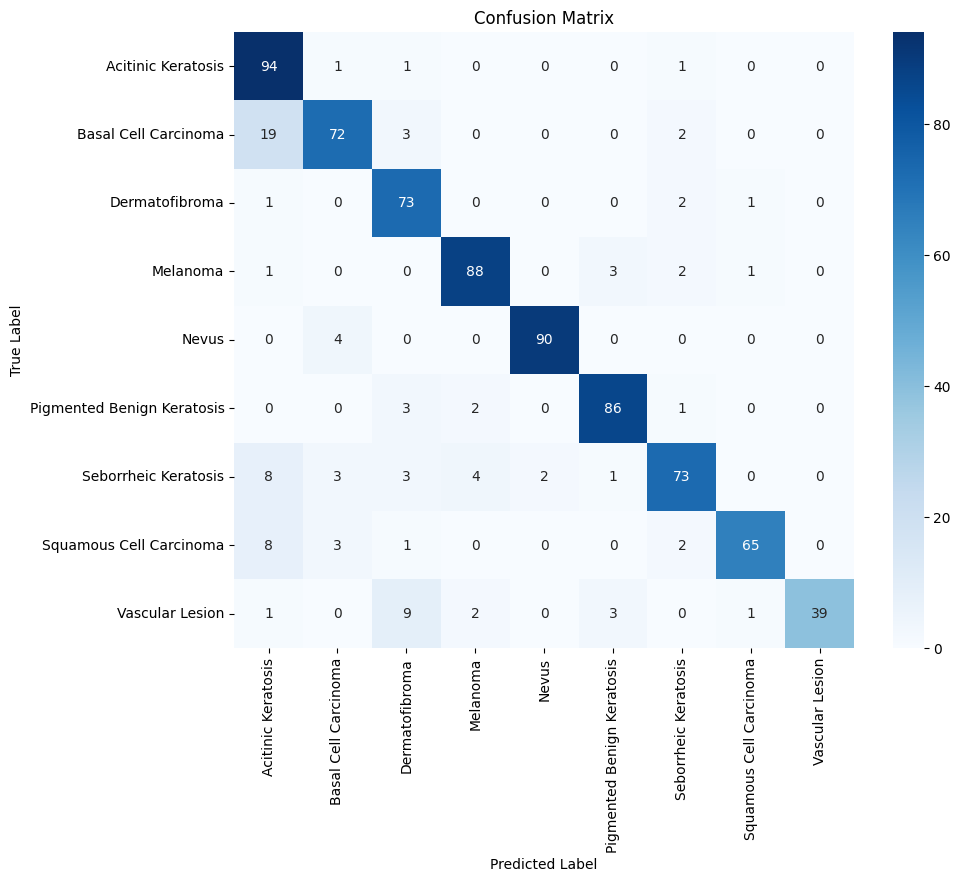

In [17]:
# Ensure the generator is reset
test_generator.reset()

# Calculate the correct number of steps
test_steps = math.ceil(test_generator.samples / test_generator.batch_size)

# Make predictions
predictions = model.predict(test_generator, steps=test_steps, verbose=1)

# Convert predicted probabilities to class labels
y_pred = np.argmax(predictions, axis=1)

# Get the true labels
y_true = test_generator.classes

# Check if the lengths of y_true and y_pred are consistent
print(f"Length of true labels (y_true): {len(y_true)}")
print(f"Length of predicted labels (y_pred): {len(y_pred)}")

# Ensure the length of y_true and y_pred match
if len(y_true) != len(y_pred):
    raise ValueError(f"Mismatch in number of true labels and predicted labels: {len(y_true)} vs {len(y_pred)}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Classification report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [18]:
model.save("skindisease.keras")